In [2]:
import tensorflow as tf
import os
import cv2
import pickle


In [28]:
d_dir = "data_faces/train/drowsiness"
ud_dir = "data_faces/train/undrowsiness"

d_img = os.listdir(d_dir)
ud_img = os.listdir(ud_dir)

print(d_img[:10])
print(ud_img[:10])

['10.mp4_0.jpg', '10.mp4_1.jpg', '10.mp4_10.jpg', '10.mp4_100.jpg', '10.mp4_101.jpg', '10.mp4_102.jpg', '10.mp4_103.jpg', '10.mp4_104.jpg', '10.mp4_105.jpg', '10.mp4_106.jpg']
['0.mp4_401.jpg', '0.mp4_402.jpg', '0.mp4_403.jpg', '0.mp4_404.jpg', '0.mp4_405.jpg', '0.mp4_406.jpg', '0.mp4_407.jpg', '0.mp4_408.jpg', '0.mp4_409.jpg', '0.mp4_410.jpg']


In [24]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=X.shape[1:]),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('undrowsiness') and 0 for the other ('drowsiness')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

In [26]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001) , loss = 'binary_crossentropy', metrics = ['accuracy'])

# model.compile(optimizer=RMSprop(lr=0.001),
#               loss='binary_crossentropy',
#               metrics = ['accuracy'])

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = "data_faces"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode = 'nearest')
test_datagen  = ImageDataGenerator( rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode = 'nearest')

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 937 images belonging to 2 classes.
Found 128 images belonging to 2 classes.


In [23]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=5,
                              verbose=2)

Epoch 1/5
47/47 - 54s - loss: 0.1268 - accuracy: 0.9530 - val_loss: 0.6226 - val_accuracy: 0.6797
Epoch 2/5
47/47 - 56s - loss: 0.1027 - accuracy: 0.9626 - val_loss: 0.3491 - val_accuracy: 0.8125
Epoch 3/5
47/47 - 66s - loss: 0.0716 - accuracy: 0.9723 - val_loss: 0.2087 - val_accuracy: 0.8828
Epoch 4/5
47/47 - 58s - loss: 0.0628 - accuracy: 0.9787 - val_loss: 0.4724 - val_accuracy: 0.7266
Epoch 5/5
47/47 - 56s - loss: 0.0828 - accuracy: 0.9733 - val_loss: 0.2637 - val_accuracy: 0.8281


# Visualization Intermediate Representation

c:\users\se7en\anaconda3\envs\kaif\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


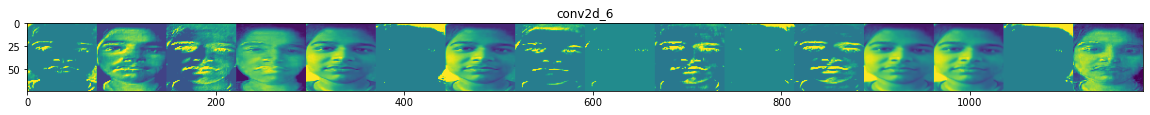

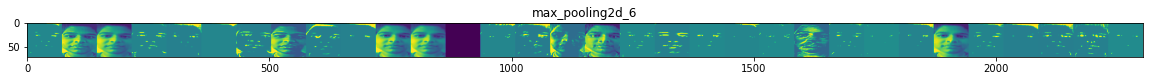

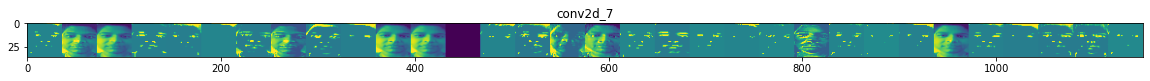

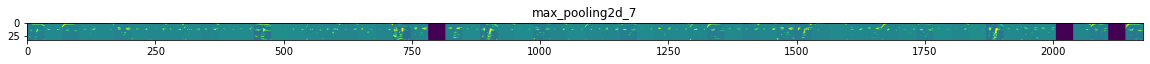

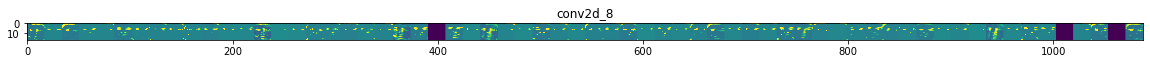

In [29]:
import matplotlib.pyplot as plt 
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
d_img_files = [os.path.join(d_dir, f) for f in d_img]
ud_img_files = [os.path.join(ud_dir, f) for f in ud_img]

img_path = random.choice(d_img_files + ud_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Text(0.5, 1.0, 'Training and validation loss')

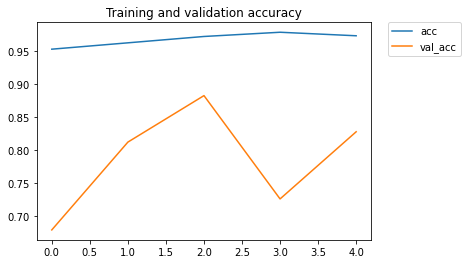

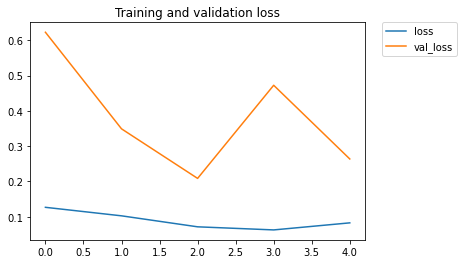

In [37]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc , label="acc" )
plt.plot  ( epochs, val_acc , label="val_acc" )
plt.title ('Training and validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label = "loss" )
plt.plot  ( epochs, val_loss , label="val_loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title ('Training and validation loss'   )

In [38]:
model.save('model_faces.h5')

In [39]:
import tensorflow as tf
import os
import cv2
import pickle
import matplotlib.pyplot as plt
model = tf.keras.models.load_model('model_faces.h5')
face_cascade = cv2.CascadeClassifier("data/haarcascade_frontalface_alt.xml")
def prepare(path):
    size = 150
    img_array = cv2.imread(path)
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.2, minNeighbors = 7)
    for (x,y,w,h) in faces:
#         print(x,y,w,h)
        roi_image = img_array[y:y+h,x:x+w]
        roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
        roi_image = cv2.resize(roi_image ,(size , size))
        return roi_image.reshape(-1 , size , size , 3)
    img_array = cv2.resize(img_array , (size,size))
    return img_array.reshape(-1 , size , size , 3)

undrowsiness


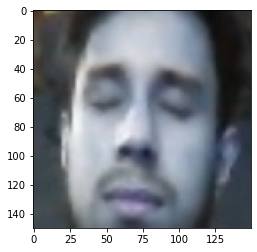

[[1.]]


In [44]:
labels = ["drowsiness" , "undrowsiness"]
pre = model.predict([prepare("vivek_drowsiness.mp4_337.jpg")])
print(labels[int(pre[0][0])])
img_array = cv2.imread('vivek_drowsiness.mp4_337.jpg')
img_array = cv2.resize(img_array , (150,150))
plt.imshow(img_array , cmap = "gray")
plt.show()
print(pre)

In [41]:
cap = cv2.VideoCapture(0)
label = "Test"
count = 0
size = 150
labels = ["drowsiness" , "undrowsiness"]
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.2, minNeighbors = 5)
    for (x,y,w,h) in faces:
#         print(x,y,w,h)
        roi_image = frame[y:y+h,x:x+w]
        roi_image = cv2.resize(roi_image , (size , size))
        pre = model.predict([roi_image.reshape(-1,150,150,3)])
        color = (0,45,255)
        stroke = 2
        end_x = x+w
        end_y = y+h
        cv2.rectangle(frame, (x,y), (end_x,end_y), color, stroke)
        label = labels[int(pre[0][0])]
        print(label,pre)

    cv2.putText(frame,label, (0,420), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,45,255))
    cv2.imshow('frame',frame)
    count+=1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[4.345729e-28]]
drowsiness [[0.9997831]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.01256671]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[3.209197

undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
undrowsiness [[1.]]
drowsiness [[0.]]
drowsiness [[2.8858403e-06]]
drowsiness [[1.1968703e-23]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.0002081]]
drowsiness [[8.17816e-15]]
drowsiness [[1.3608251e-28]]
drowsiness [[2.5864067e-34]]
drowsiness [[0.]]
drowsiness [[0.00043722]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[0.]]
drowsiness [[1.2609138e-18]]
drowsiness [[